In [1]:
from matplotlib import pyplot as plt

def imshow(img):
    import torch
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    plt.imshow(img)
    plt.show()

In [2]:
import torch
import transformers

/home/ainl/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TEXTS = [
    "Hello, World! [SEP] I love cats.",
    "This is the example [SEP] I want to be happy",
    "Ask not what your country can do for you [SEP] Ask what you can do for your country.",
]

model_id_hf = 'bert-base-uncased'
tokenizer = transformers.BertTokenizerFast.from_pretrained(model_id_hf)
tokenized_result = tokenizer(TEXTS, padding=True, max_length=512, truncation=True, return_tensors="pt")
tokenized_result['input_ids'], tokenizer.decode(tokenized_result['input_ids'][0])

(tensor([[ 101, 7592, 1010, 2088,  999,  102, 1045, 2293, 8870, 1012,  102,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 101, 2023, 2003, 1996, 2742,  102, 1045, 2215, 2000, 2022, 3407,  102,
             0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 101, 3198, 2025, 2054, 2115, 2406, 2064, 2079, 2005, 2017,  102, 3198,
          2054, 2017, 2064, 2079, 2005, 2115, 2406, 1012,  102]]),
 '[CLS] hello, world! [SEP] i love cats. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]')

In [4]:
# Manual top-k
from models import sparse_token as sparse
from trainer import glue_base

topk_trainer = glue_base.GlueAttentionApproxTrainer('mrpc', factor=4, batch_size=1, wiki_train=False, device='cpu')
target_ks = 0.5
if target_ks <= 0.666:
    ksx = [target_ks*0.5+((1-x/10.0)**1.0) * target_ks for x in range(12)]
else:
    ksx = [(1-x/10.0)*(2-2*target_ks)+(2*target_ks-1) for x in range(12)]


Trainer: mrpc
Trainer: Checkpoint path saves/glue-mrpc-4.pth


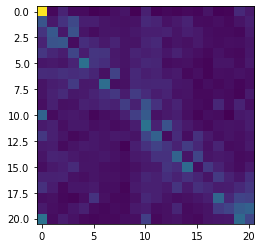

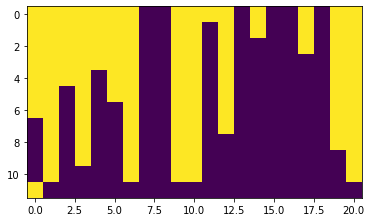

In [7]:
BATCH_IDX = 2
wrapped_bert = sparse.ApproxSparseBertModel(topk_trainer.model_bert, approx_bert=topk_trainer.approx_bert.module, ks=ksx)
wrapped_bert.use_forward_sparse = True
wrapped_bert.run_original_attention = False
wrapped_bert.sparse_bert.load_state_dict(topk_trainer.model.bert.state_dict(), strict=False)
wrapped_bert.to('cpu')

output = wrapped_bert(
    input_ids=tokenized_result['input_ids'], 
    attention_mask=tokenized_result['attention_mask'],
    output_attentions=True
)
imshow(torch.mean(output['attentions'][0][BATCH_IDX], dim=0))

masks = []
for layer in wrapped_bert.sparse_bert.encoder.layer:
    indices = layer.output.dense.channel_indices
    mask = torch.zeros(tokenized_result['input_ids'].shape[0], tokenized_result['input_ids'].shape[1], device='cpu', dtype=torch.float32)\
        .scatter_(1, indices.squeeze(-1), 1.0)
    masks.append(mask[BATCH_IDX])
imshow(torch.stack(masks, dim=0))

In [2]:
# Attention back-tracking

In [ ]:
# Concrete masking